In [1]:
!pip install keras-tuner

In [2]:
# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, AveragePooling1D , Flatten, Input, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
import pprint as pp
import keras_tuner as kt
from tensorflow.keras.utils import plot_model
from sklearn.utils import shuffle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


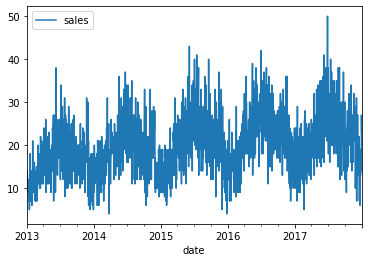

In [4]:
df = pd.read_excel("/content/drive/MyDrive/dataset.xlsx")
df.plot(x = 'date', y = 'sales')
plt.show()

In [5]:
raw_seq = df['sales']

In [6]:
train_seq = raw_seq[:1095]
val_seq = raw_seq[1095:1461].reset_index(drop=True)
test_seq = raw_seq[1461:].reset_index(drop=True)

In [7]:
print(train_seq.size, val_seq.size, test_seq.size)

1095 366 365


In [8]:
# univariate data preparation
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [9]:
n_steps = 30
n_features = 1
X_train, y_train = split_sequence(train_seq, n_steps)
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=10)
X_test, y_test = split_sequence(test_seq, n_steps)
X_val, y_val = split_sequence(val_seq, n_steps)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [10]:
def bidirectional_LSTM(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(30, 1)))

    for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
      model.add(Bidirectional(LSTM(units=hp.Int('units' + str(i), min_value=32, max_value=512, step=32), activation='tanh', recurrent_activation='sigmoid', return_sequences=True)))
      model.add(Dropout(hp.Float('dropout' + str(i), 0, 0.5, step=0.1, default=0)))
    
    model.add(Flatten())
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])

    return model

In [11]:
tuner = kt.tuners.Hyperband(
    bidirectional_LSTM,
    objective='val_mean_squared_error',
    max_epochs=30,
    hyperband_iterations=5,
    directory='birectional_lstm_exp',
    project_name='demand forecasting')

INFO:tensorflow:Reloading Oracle from existing project birectional_lstm_exp/demand forecasting/oracle.json
INFO:tensorflow:Reloading Tuner from birectional_lstm_exp/demand forecasting/tuner0.json


In [12]:
tuner.search_space_summary()

Search space summary
Default search space size: 23
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout0 (Float)
{'default': 0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout1 (Float)
{'default': 0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout2 (Float)
{'default': 0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout3 (Float)
{'default'

In [13]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [14]:
tuner.search(X_train_shuffled, y_train_shuffled, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

Trial 59 Complete [00h 00m 55s]
val_mean_squared_error: 42.12250900268555

Best val_mean_squared_error So Far: 25.080833435058594
Total elapsed time: 01h 45m 25s

Search: Running Trial #60

Value             |Best Value So Far |Hyperparameter
18                |2                 |num_layers
384               |192               |units0
0                 |0.1               |dropout0
480               |96                |units1
0.2               |0.1               |dropout1
128               |96                |units2
0.4               |0.1               |dropout2
448               |320               |units3
0.1               |0.2               |dropout3
96                |64                |units4
0.2               |0.2               |dropout4
96                |320               |units5
0.4               |0.1               |dropout5
384               |320               |units6
0.3               |0.3               |dropout6
96                |352               |units7
0.2               |

KeyboardInterrupt: ignored

In [15]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(30, 1))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 30, 384)          297984    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 384)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 30, 192)          369408    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 192)           0         
                                                                 
 flatten (Flatten)           (None, 5760)              0         
                                                                 
 dense (Dense)               (None, 1)                 5

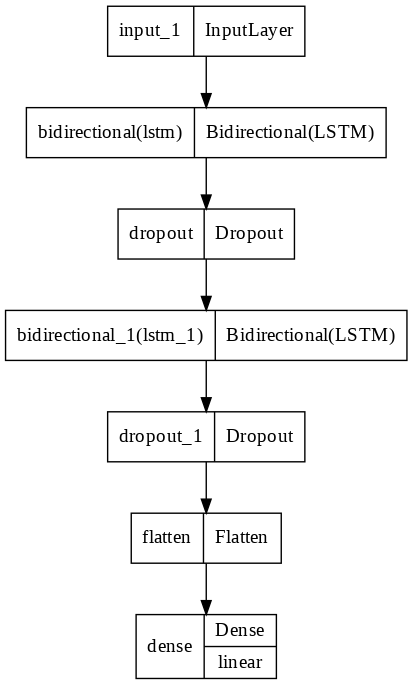

In [16]:
plot_model(best_model,  show_layer_activations=True, dpi=100)

In [17]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

In [18]:
hist =  best_model.fit(X_train, y_train, batch_size=120, epochs=2000, verbose=2, validation_data=(X_val, y_val), callbacks=[callback])
score = best_model.evaluate(X_test, y_test, return_dict=True)
y_pred = best_model.predict(X_test)

Epoch 1/2000
9/9 - 9s - loss: 22.0842 - mean_absolute_error: 3.6807 - root_mean_squared_error: 4.6994 - mean_absolute_percentage_error: 22.9123 - mean_squared_error: 22.0842 - val_loss: 25.0425 - val_mean_absolute_error: 3.9881 - val_root_mean_squared_error: 5.0043 - val_mean_absolute_percentage_error: 20.2091 - val_mean_squared_error: 25.0425 - 9s/epoch - 1s/step
Epoch 2/2000
9/9 - 1s - loss: 21.8468 - mean_absolute_error: 3.6756 - root_mean_squared_error: 4.6741 - mean_absolute_percentage_error: 23.2528 - mean_squared_error: 21.8468 - val_loss: 25.0254 - val_mean_absolute_error: 3.9876 - val_root_mean_squared_error: 5.0025 - val_mean_absolute_percentage_error: 20.1545 - val_mean_squared_error: 25.0254 - 562ms/epoch - 62ms/step
Epoch 3/2000
9/9 - 1s - loss: 21.6665 - mean_absolute_error: 3.6687 - root_mean_squared_error: 4.6547 - mean_absolute_percentage_error: 22.9965 - mean_squared_error: 21.6665 - val_loss: 25.4733 - val_mean_absolute_error: 4.0158 - val_root_mean_squared_error: 5.

In [19]:
best_model.evaluate(X_train, y_train, return_dict=True)

34/34 [==============================] - 1s 17ms/step - loss: 18.9305 - mean_absolute_error: 3.4209 - root_mean_squared_error: 4.3509 - mean_absolute_percentage_error: 21.2693 - mean_squared_error: 18.9305


{'loss': 18.930532455444336,
 'mean_absolute_error': 3.420928955078125,
 'mean_absolute_percentage_error': 21.26926040649414,
 'mean_squared_error': 18.930532455444336,
 'root_mean_squared_error': 4.350923538208008}

In [20]:
best_model.evaluate(X_val, y_val, return_dict=True)

11/11 [==============================] - 0s 17ms/step - loss: 24.4356 - mean_absolute_error: 3.9013 - root_mean_squared_error: 4.9432 - mean_absolute_percentage_error: 19.5264 - mean_squared_error: 24.4356


{'loss': 24.43563461303711,
 'mean_absolute_error': 3.9013218879699707,
 'mean_absolute_percentage_error': 19.526411056518555,
 'mean_squared_error': 24.43563461303711,
 'root_mean_squared_error': 4.943241596221924}

In [21]:
score

{'loss': 27.240978240966797,
 'mean_absolute_error': 4.169180870056152,
 'mean_absolute_percentage_error': 20.67784881591797,
 'mean_squared_error': 27.240978240966797,
 'root_mean_squared_error': 5.219289302825928}

In [22]:
print(hist.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'mean_absolute_percentage_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'val_mean_absolute_percentage_error', 'val_mean_squared_error'])


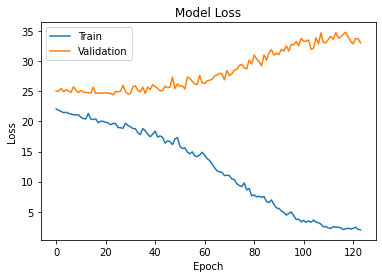

In [23]:
# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("bidirectional_lstm_loss.png", dpi=300)
plt.show()

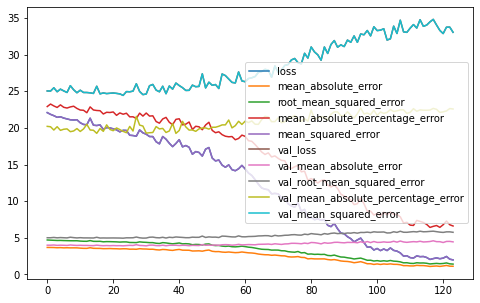

In [24]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.show()

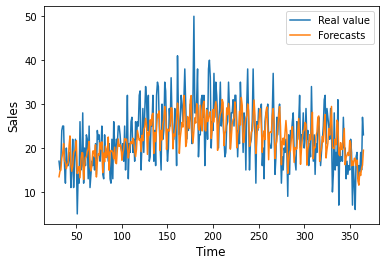

In [25]:
dates = np.array(range(31, 366))
plt.plot(dates, y_test, label='Real value')
plt.plot(dates, y_pred, label='Forecasts')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.savefig("bidirectional_lstm_forecast.png", dpi=500)
plt.show()

In [26]:
from scipy import stats
stats.ttest_ind(y_pred, y_test)

Ttest_indResult(statistic=array([-1.1558907], dtype=float32), pvalue=array([0.24813911]))

In [27]:
best_model.save('bidirectional_lstm.h5')